## <div align="center">Forecasting ICU Survival - MIMIC-III</div>
                                                                        
    1. Project Definition
    2. Analysis
    3. Methodology
    4. Results
    5. Conclusion
    
    
[GitHub](https://github.com/stiven0210/ICU_Survival_Prediction_Capstone.git)  

[Medium](https://medium.com/@stiven02.0/icu-survival-prediction-9736c1936ec3)
    


### <div align="center">1. Project Definition</div>

### Introduction

### Project Overview

This project intends to illustrate the procedure for choosing a specific group of patients, preparing the data to facilitate exploratory visualization, and constructing a classification model to foresee mortality post-ICU admission. This endeavor involves the analysis of initial notes provided by caregivers.

### Problem Statement
The objective is to recognize potential high-risk patients and endeavor to anticipate the likelihood of survival post-ICU admission. In scenarios of diminished likelihood, proactive steps should be taken for intervention.

#### Data Set

MIMIC-III (Medical Information Mart for Intensive Care III) is an expansive and openly accessible database that encompasses de-identified health-related data linked to more than forty thousand patients who were admitted to critical care units at the Beth Israel Deaconess Medical Center between 2001 and 2012.

This comprehensive database comprises a wealth of information, including patient demographics, vital sign measurements collected at the bedside (approximately 1 data point per hour), laboratory test results, medical procedures, medication details, caregiver notes, imaging reports, and records of mortality both within and outside the hospital setting.

The availability of MIMIC is primarily attributed to the collaborative efforts of researchers at the MIT Laboratory for Computational Physiology and other research groups working in tandem.

#### Dataset sourced from
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. 

https://mimic.physionet.org/


### Metrics

We will assess the effectiveness of machine learning models by analyzing their accuracy and employing a confusion matrix for a comprehensive evaluation. The classification report provides a holistic view, presenting essential metrics such as precision, recall, f1-score, and support.

### <div align="center">2. Analysis</div>

The focus of this project will involve the selection of ICU patients within the age range of 18 to 100. 

#### Database Setup: PostgreSQL

Guide to Installing MIMIC-III in a Local Postgres Database on Windows

https://mimic.physionet.org/tutorials/install-mimic-locally-windows/

Before you proceed with the steps outlined in this guide, make sure to complete the following prerequisites:

    a. Download the MIMIC-III Clinical Database.
    b. Extract the MIMIC-III Clinical Database as .csv files to a directory on your local computer.
    c. Obtain the necessary PostgreSQL scripts. You'll only need the files with .sql extensions.

Message: The PostgreSQL database, tables, and data were successfully created. However, a significant amount of information was missing or inaccurate. Therefore, it's crucial to supplement certain details to fulfill this purpose.

#### Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

# Set the style for matplotlib
style.use('ggplot')

# Install psycopg2 package
!pip install psycopg2

# Import psycopg2 and getpass
import psycopg2
import getpass

#### Connection Database

In [2]:
# Database connection parameters
sqluser = 'postgres'
host = 'localhost'
schema_name = 'mimiciii'
dbname = 'mimic'

# Get the password securely
password = getpass.getpass(prompt='Enter your password for {}: '.format(sqluser))

# Establish the database connection
con = psycopg2.connect(dbname=dbname, user=sqluser, host=host, password=password)
cur = con.cursor()

# Set the search path to the specified schema
cur.execute('SET search_path to {}'.format(schema_name))

Enter your password for postgres: ········


#### Validate database connection

In [3]:
# SQL query
query = """
SELECT *
  FROM {}.icustays
""".format(schema_name)

# Read data into DataFrame
df = pd.read_sql_query(query, con)

# Display the first few rows of the DataFrame
df.head()


C:\Users\ususoporte\AppData\Local\Temp\ipykernel_12428\2700564603.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con)


,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,12742,10006,142345,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325
1,12747,10011,105331,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507
2,12749,10013,165520,264446,carevue,MICU,MICU,15,15,2125-10-04 23:38:00,2125-10-07 15:13:52,2.6499
3,12754,10017,199207,204881,carevue,CCU,CCU,7,7,2149-05-29 18:52:29,2149-05-31 22:19:17,2.1436
4,12755,10019,177759,228977,carevue,MICU,MICU,15,15,2163-05-14 20:43:56,2163-05-16 03:47:04,1.2938


#### Noteevents Table

Feature manipulation: "storetime_order" was devised based on the sequencing of "storetime". This empowers me to retain solely the initial note subsequent to ICU admission.

Following that, organize the data by chartdate and storetime in order to exclusively pick the initial note upon admission to the hospital. Exclude notes in the categories of ECG, Echo, Radiology, and Discharge summary due to the absence of dates. This partition is carried out based on subject_id & hadm_id.

Table with reconstructed information

In [4]:
# SQL query
query = """
WITH a AS (
    SELECT subject_id, 
           hadm_id, 
           chartdate, 
           storetime, 
           category, 
           text, 
           RANK() OVER (PARTITION BY subject_id, hadm_id ORDER BY chartdate, storetime) AS storetime_order
    FROM {}.noteevents
    WHERE category NOT IN ('ECG', 'Echo', 'Radiology', 'Discharge summary')
)

SELECT *, 
    CASE
        WHEN storetime_order > 1 THEN 1
        ELSE 0 
    END AS exclusion_storetime_order
FROM a
WHERE storetime_order = 1
ORDER BY subject_id, hadm_id, chartdate, storetime
""".format(schema_name)

# Read data into DataFrame
df_nts = pd.read_sql_query(query, con)

# Display the first few rows of the DataFrame
df_nts.head()

C:\Users\ususoporte\AppData\Local\Temp\ipykernel_12428\2064684483.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_nts = pd.read_sql_query(query, con)


,subject_id,hadm_id,chartdate,storetime,category,text,storetime_order,exclusion_storetime_order
0,10006,142345,2023-01-15,2023-01-15 10:30:00,Nursing,This is a nursing note for the patient,1,0
1,10017,199207,2023-03-20,2023-03-20 14:20:00,Physician,Patient presents with symptoms,1,0
2,10019,177759,2023-02-10,2023-02-10 09:30:00,Pharmacy,Prescribed medications,1,0
3,10026,103770,2023-04-05,2023-04-05 16:30:00,Nursing,Patient's vitals are stable,1,0
4,10027,199395,2023-05-10,2023-05-10 10:00:00,Physician,Discussion about treatment options,1,0


In [5]:
# Display dimensions of the noteevents dataset
noteevents_dimensions = df_nts.shape
print('DataFrame dimensions for the noteevents dataset:', noteevents_dimensions)

# Display value counts for the 'category' column
category_counts = df_nts['category'].value_counts()
print(category_counts)

DataFrame dimensions for the noteevents dataset: (39, 8)
Nursing      15
Physician    13
Pharmacy     11
Name: category, dtype: int64


#### Choose patients whose ages fall within the range of 18 to 100 years from the icustays and patients tables.

1. Age was computed by determining the difference between date of birth and ICU admission time.
2. Death age was derived from the gap between date of death and date of birth.
3. Lost death was calculated based on the interval between date of death and ICU admission time, measured in days.
4. ICU admission order was established by sequencing ICU admission times, facilitating the retention of the most recent admission.

To take into account:
- To calculate age, merge multiple tables.
- Begin by selecting the icustays table and then performing an inner join with patients and admissions.
- Compute the age at admission by using icu.intime and date of birth.
- Calculate the days between ICU admission and patient's death by subtracting icu.intime from the date of death.

In [6]:
# Query to create the dataset 'df_icu'
query_icu = """
WITH aa AS (
    SELECT icu.subject_id, 
           icu.hadm_id, 
           icu.icustay_id, 
           icu.intime, 
           icu.los, 
           EXTRACT('epoch' from icu.intime - pat.dob) / (60.0 * 60.0 * 24.0 * 365.242) as age, 
           EXTRACT('epoch' from pat.dod - pat.dob) / (60.0 * 60.0 * 24.0 * 365.242) as death_age, 
           EXTRACT('epoch' from pat.dod - icu.intime) / (60.0 * 60.0 * 24.0) as los_death, 
           pat.gender, pat.dob, pat.dod, pat.dod_hosp, pat.expire_flag, 
           adm.admission_type, adm.admission_location, adm.insurance, adm.language, 
           adm.religion, adm.marital_status, adm.ethnicity, adm.diagnosis, 
           RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
    FROM mimiciii.icustays icu
    INNER JOIN mimiciii.patients pat ON icu.subject_id=pat.subject_id
    INNER JOIN mimiciii.admissions adm ON icu.hadm_id=adm.hadm_id
    where EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 < 100
)
SELECT *,
    CASE
     WHEN icustay_id_order > 1 THEN 1
     ELSE 0 
    END AS exclusion_icustay_id_order, 
    CASE
     WHEN age < 18 or age > 100 THEN 1
     ELSE 0 
    END AS exclusion_age
 FROM aa
WHERE admission_type != 'ELECTIVE'
  AND admission_type != 'NEWBORN'
"""
# Execute the query and create the dataframe 'df_icu'
df_icu = pd.read_sql_query(query_icu, con)

# Display the first few rows of the dataframe
df_icu.head()

C:\Users\ususoporte\AppData\Local\Temp\ipykernel_12428\315685900.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_icu = pd.read_sql_query(query_icu, con)


,subject_id,hadm_id,icustay_id,intime,los,age,death_age,los_death,gender,dob,...,admission_location,insurance,language,religion,marital_status,ethnicity,diagnosis,icustay_id_order,exclusion_icustay_id_order,exclusion_age
0,10006,142345,206504,2164-10-23 21:10:15,1.6325,70.637775,71.437567,292.117882,F,2094-03-05,...,EMERGENCY ROOM ADMIT,Medicare,None,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,SEPSIS,1,0,0
1,10011,105331,232110,2126-08-14 22:34:00,13.8507,36.192279,36.228035,13.059722,F,2090-06-05,...,TRANSFER FROM HOSP/EXTRAM,Private,None,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,HEPATITIS B,1,0,0
2,10013,165520,264446,2125-10-04 23:38:00,2.6499,87.087423,87.092941,2.015278,F,2038-09-03,...,TRANSFER FROM HOSP/EXTRAM,Medicare,None,CATHOLIC,None,UNKNOWN/NOT SPECIFIED,SEPSIS,1,0,0
3,10017,199207,204881,2149-05-29 18:52:29,2.1436,73.687545,76.976361,1201.213553,F,2075-09-21,...,EMERGENCY ROOM ADMIT,Medicare,None,CATHOLIC,DIVORCED,WHITE,HUMERAL FRACTURE,1,0,0
4,10019,177759,228977,2163-05-14 20:43:56,1.2938,48.901451,48.901824,0.136157,M,2114-06-20,...,TRANSFER FROM HOSP/EXTRAM,Medicare,None,CATHOLIC,DIVORCED,WHITE,ALCOHOLIC HEPATITIS,1,0,0


In [7]:
# Display dataset dimensions
print(f'Dataset Dimensions: {df_icu.shape}')

# Display value counts for 'admission_type' column
admission_type_counts = df_icu['admission_type'].value_counts()
print(admission_type_counts)

Dataset Dimensions: (119, 24)
EMERGENCY    117
URGENT         2
Name: admission_type, dtype: int64


In [8]:
#Closing the database connection
con.close()

#### Perform an inner join between the two dataframes to obtain the final dataset: df_icu and df_nts.

In [9]:
# Print the dimensions of the noteevents dataset
print(f'Shape of the noteevents dataset: {df_nts.shape}')

# Print the dimensions of the icu-adm-pat dataset
print(f'Shape of the icu-adm-pat dataset: {df_icu.shape}')

Shape of the noteevents dataset: (39, 8)
Shape of the icu-adm-pat dataset: (119, 24)


In [10]:
# Inner join the dataframes
df = df_nts.merge(df_icu, on=['subject_id', 'hadm_id'], how='inner')

# Print the dimensions of the merged dataframe
print(f'Merged DataFrame dimensions: {df.shape}.')


Merged DataFrame dimensions: (22, 30).


#### Refine the data by retaining the latest ICU records and excluding cases with negative days between admission and death.

Anomalies detected: certain entries display negative "los_death," indicating that the reported time of death is earlier than the ICU admission time. These entries have been excluded from this dataset.

To take into account:
- Organize the dataframe by sorting it according to subject_id and icu.intime. Retain only the latest record for each subject_id and discard all other records.
- Segment the dataframe by filtering ages between 18 and 100.
- Exclude anomalies where the period from ICU entry to death is negative, which might be due to mislabeling.
- Choose specific columns.
- Examine the dimensions of the chosen dataframe.

In [11]:
# Sort the dataframe based on subject_id and intime
df_sorted = df.sort_values(by=['subject_id', 'intime'], ascending=False)

# Keep only the first record for each subject_id
df_first_entry = df_sorted.drop_duplicates(subset=['subject_id'], keep='first')

# Filter out rows with exclusion_age equals 0
df_filtered_age = df_first_entry[df_first_entry['exclusion_age'] == 0]

# Filter out rows where los_death is greater than 0 or is null
df_filtered_los_death = df_filtered_age[(df_filtered_age['los_death'] > 0) | (df_filtered_age['los_death'].isnull())]

# Select specific columns for the final dataframe
columns_to_select = ['subject_id', 'hadm_id', 'icustay_id', 'los', 'age', 'death_age', 'los_death',
                     'gender', 'admission_type', 'admission_location', 'insurance', 'language',
                     'religion', 'marital_status', 'ethnicity', 'diagnosis', 'text', 'expire_flag']
df_final = df_filtered_los_death[columns_to_select]

# Display the shape of the final dataframe
final_dimensions = df_final.shape
print('Shape of the final dataframe:', final_dimensions)

Shape of the final dataframe: (20, 18)


In [12]:
# Calculate the normalized value counts of expire_flag column
expire_flag_counts = df['expire_flag'].value_counts(normalize=True)

# Display the normalized value counts
print(expire_flag_counts)

1    0.909091
0    0.090909
Name: expire_flag, dtype: float64


#### Save the data for future reuse

In [13]:
# Define the filename
filename = 'mimic_mortality.csv'

# Save the DataFrame to a CSV file
df.to_csv(filename, index=False)

#### Death days distribution

Irregularities: Certain entries have been identified with negative "los_death" values, indicating that the reported time of death is before the ICU admission time. These entries have been excluded from the dataset. As demonstrated below, the dataset does not contain any negative "los_death" values.

count      20.000000
mean      396.345602
std       643.877673
min         0.136157
25%         5.995298
50%        79.399954
75%       329.717867
max      2124.983380
Name: los_death, dtype: float64


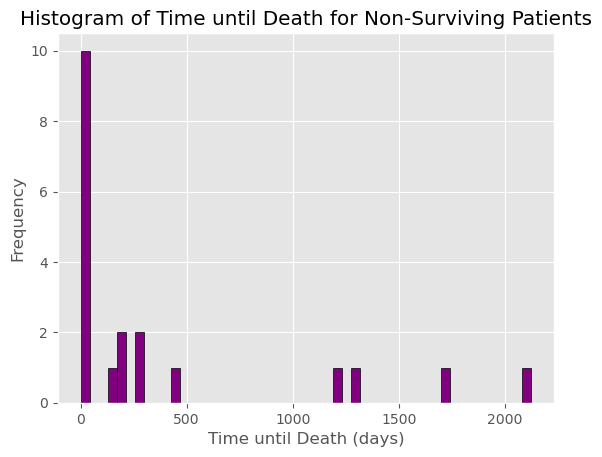

In [14]:
# Summary statistics of time until death for non-surviving patients
summary_stats = df[df.expire_flag==1]['los_death'].describe()
print(summary_stats)

# Histogram of time until death for non-surviving patients
summary_color = 'green'
histogram_color = 'purple'
plt.hist(df[df.expire_flag==1]['los_death'], bins=50, color=histogram_color, edgecolor='black')
plt.xlabel('Time until Death (days)')
plt.ylabel('Frequency')
plt.title('Histogram of Time until Death for Non-Surviving Patients')
plt.grid(True)
plt.show()

#### Age distributions for patients survived 

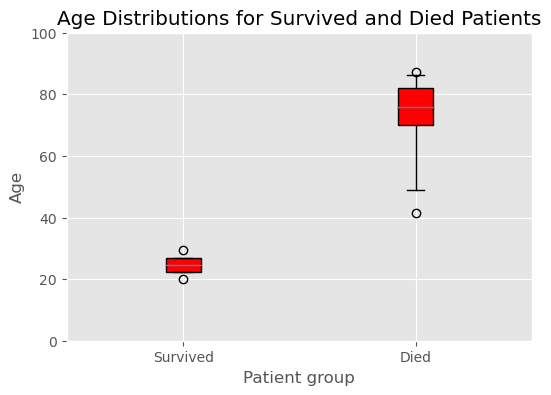

In [15]:
# Filter age for patients survived and died
age_survived = df[df.expire_flag == 0]['age']
age_died = df[df.expire_flag == 1]['age']

# Create a figure instance
fig, ax = plt.subplots(figsize=(6, 4))

# Define color
boxplot_color = 'red'

# Create a boxplot with adjusted whis values and age range
ax.boxplot([age_survived, age_died], whis=[1, 99], patch_artist=True, boxprops=dict(facecolor=boxplot_color))  
ax.set_xticklabels(['Survived', 'Died'])
ax.set_xlabel('Patient group')
ax.set_ylabel('Age')
ax.set_title('Age Distributions for Survived and Died Patients')

# Set y-axis limit to 100
ax.set_ylim(0, 100)

# Show the plot
plt.show()

#### Distributions of marital status among all patients

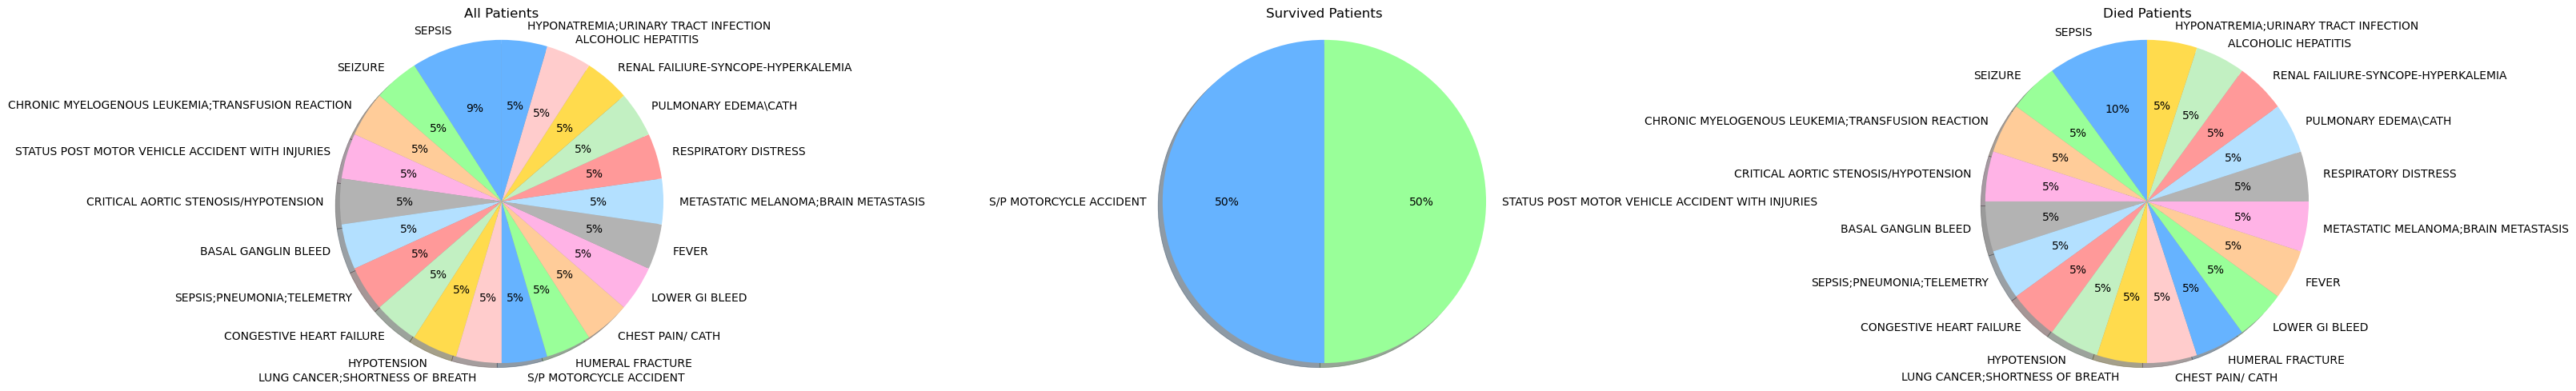

In [16]:
import matplotlib.pyplot as plt

# Filter diagnosis for all patients, survived patients, and died patients
diagnosis_all = df['diagnosis']
diagnosis_survived = df[df.expire_flag == 0]['diagnosis']
diagnosis_died = df[df.expire_flag == 1]['diagnosis']

# Cutoff percentage for display
pct_cutoff = 2

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure and create subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 5))  # 1 row, 3 columns

# Colors for the pie charts
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ffb3e6', '#b3b3b3', '#b3e0ff', '#ff9999', '#c2f0c2', '#ffdb4d', '#ffcccc']

# Loop through each group of patients (all, survived, died)
for i, diagnosis_group in enumerate([diagnosis_all, diagnosis_survived, diagnosis_died]):
    ax = axes[i]
    
    # Slice the DataFrame for the specific patient group and diagnosis
    diagnosis_counts = diagnosis_group.value_counts(normalize=True)
    
    # Filter diagnoses with percentage above the cutoff
    diagnosis_counts = diagnosis_counts[diagnosis_counts > pct_cutoff / 100]
    
    # Generate the pie plot with custom colors
    ax.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct=my_autopct, colors=colors, startangle=90, shadow=True)
    
    # Set axis, title, and adjust layout
    ax.axis('equal')
    ax.set_title(['All Patients', 'Survived Patients', 'Died Patients'][i], fontsize=12)

# Adjust layout spacing
plt.tight_layout()

# Display the plots
plt.show()


#### Distribution of Age and Gender among Different Patient Groups

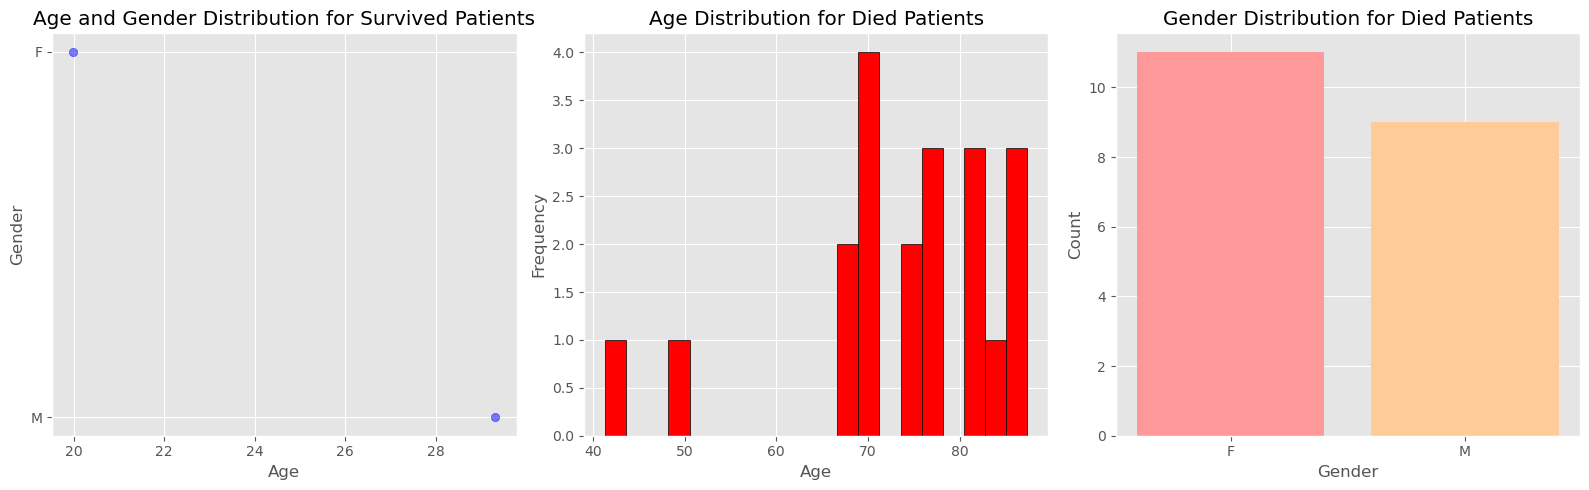

In [17]:
import matplotlib.pyplot as plt

# Filter age and gender for all patients, survived patients, and died patients
age_survived = df[df.expire_flag == 0]['age']
age_died = df[df.expire_flag == 1]['age']

gender_survived = df[df.expire_flag == 0]['gender']
gender_died = df[df.expire_flag == 1]['gender']

# Set the size of the figure and create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # 1 row, 3 columns

# Age and Gender Distribution for Survived Patients
ax = axes[0]
ax.scatter(age_survived, gender_survived, color='blue', alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Gender')
ax.set_title('Age and Gender Distribution for Survived Patients')

# Age Distribution for Died Patients
ax = axes[1]
ax.hist(age_died, bins=20, color='red', edgecolor='black')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution for Died Patients')

# Gender Distribution for Died Patients
ax = axes[2]
gender_counts_died = gender_died.value_counts()
ax.bar(gender_counts_died.index, gender_counts_died.values, color=['#ff9999', '#ffcc99'])
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Gender Distribution for Died Patients')

# Adjust layout spacing
plt.tight_layout()

# Display the plots
plt.show()


#### Examination of the Most Common Diagnoses in Admissions

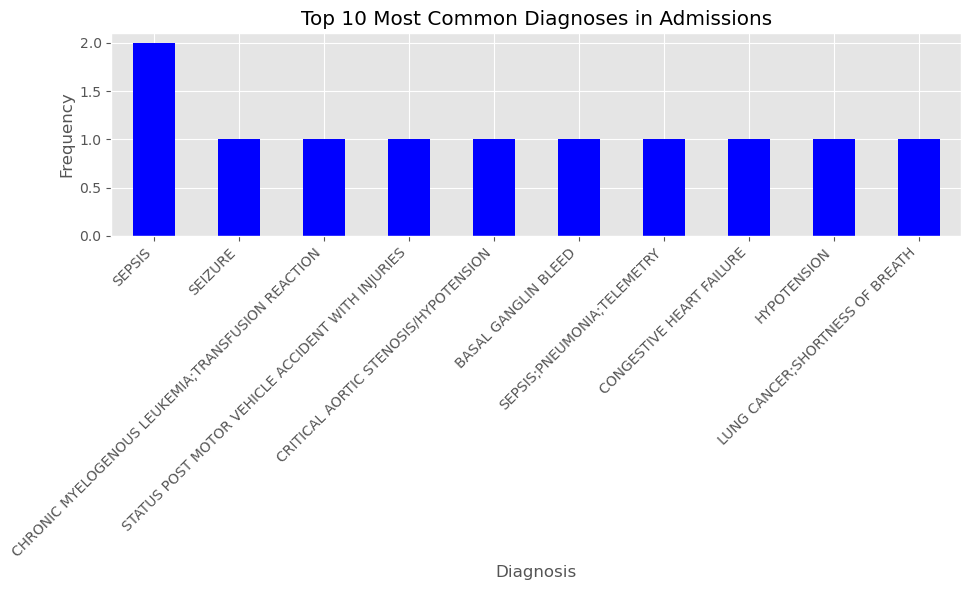

In [18]:
# Filter and count the most common diagnoses in admissions
top_diagnoses = df['diagnosis'].value_counts().head(10)

# Create a bar plot for the most common diagnoses
plt.figure(figsize=(10, 6))
top_diagnoses.plot(kind='bar', color='blue')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Diagnoses in Admissions')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()

# Display the plot
plt.show()


#### Exploration of ICU Stay Duration by Patient Outcome

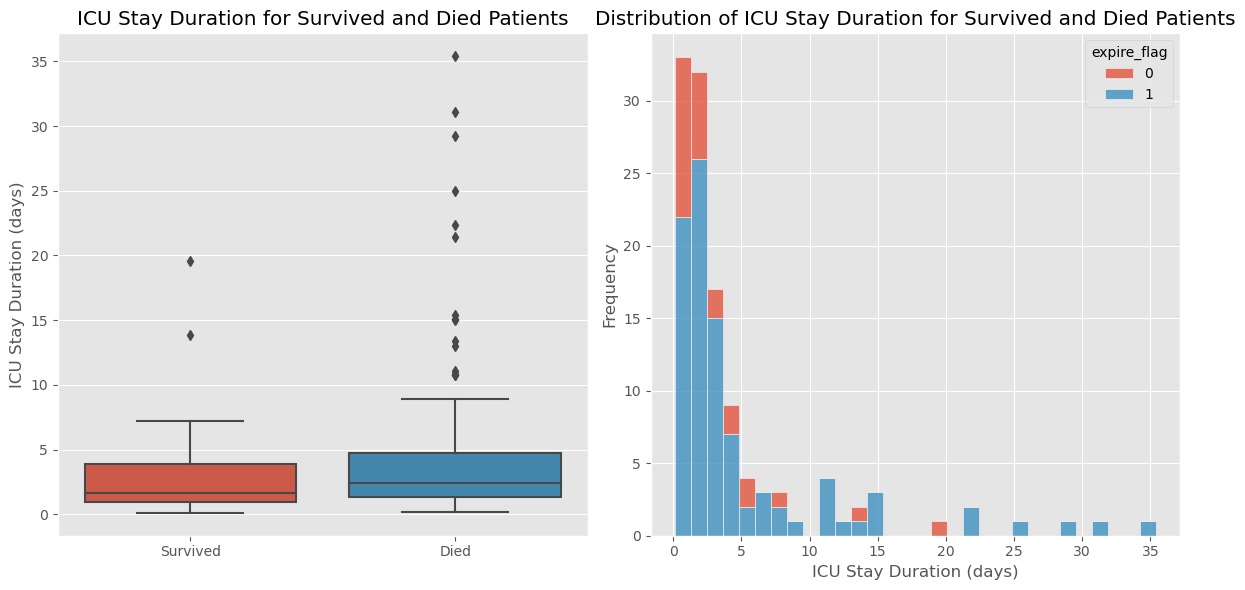

In [19]:

# Filter data for patients who either survived or died in the ICU
df_icu_survived = df_icu[df_icu['expire_flag'] == 0]
df_icu_died = df_icu[df_icu['expire_flag'] == 1]

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Box plot of ICU stay duration for Survived and Died patients
sns.boxplot(data=[df_icu_survived['los'], df_icu_died['los']], ax=axes[0])
axes[0].set_xticklabels(['Survived', 'Died'])
axes[0].set_ylabel('ICU Stay Duration (days)')
axes[0].set_title('ICU Stay Duration for Survived and Died Patients')

# Histogram of ICU stay duration for Survived and Died patients
sns.histplot(data=df_icu, x='los', hue='expire_flag', bins=30, multiple='stack', ax=axes[1])
axes[1].set_xlabel('ICU Stay Duration (days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of ICU Stay Duration for Survived and Died Patients')

# Adjust layout spacing
plt.tight_layout()

# Display the plots
plt.show()


#### Age Difference Analysis: Survived vs. Died Patients

In [22]:
# Calculate age statistics for different patient groups
age_all = df['age']
age_survived = df[df.expire_flag == 0]['age']
age_died = df[df.expire_flag == 1]['age']

# Calculate statistics for age among different patient groups
age_stats = {
    'All Patients': {
        'average': age_all.mean(),
        'std_deviation': age_all.std()
    },
    'Survived Patients': {
        'average': age_survived.mean(),
        'std_deviation': age_survived.std()
    },
    'Died Patients': {
        'average': age_died.mean(),
        'std_deviation': age_died.std()
    }
}

# Print the calculated statistics
for group, stats in age_stats.items():
    print(f"{group}:\n"
          f" - Average age: {stats['average']:.2f}\n"
          f" - Standard deviation: {stats['std_deviation']:.2f}\n")


All Patients:
 - Average age: 69.39
 - Standard deviation: 18.29

Survived Patients:
 - Average age: 24.66
 - Standard deviation: 6.60

Died Patients:
 - Average age: 73.86
 - Standard deviation: 11.65



#### Age Distribution Comparison: Survived vs. Died Patients

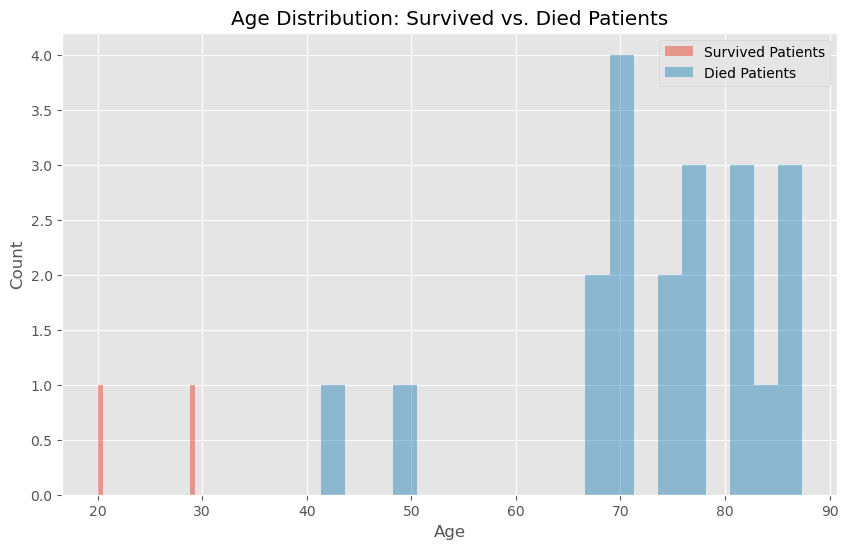

In [23]:
plt.figure(figsize=(10, 6))

# Plot histogram for patients who survived
plt.hist(age_survived, bins=20, alpha=0.5, label='Survived Patients')

# Plot histogram for patients who died
plt.hist(age_died, bins=20, alpha=0.5, label='Died Patients')

# Add legend and labels
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution: Survived vs. Died Patients')

# Display the plot
plt.show()


### <div align="center">3. Methodology</div>
a. Logistic Regression Model
b. Random Forest Classification Model

#### Utilization of Machine Learning Models and Train-Test Data Division

In [24]:

# import libraries
import time
import pickle
import re
import nltk
!pip install xgboost
nltk.download(['punkt','wordnet','averaged_perceptron_tagger','stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ususoporte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ususoporte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ususoporte\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ususoporte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Import the required library
from sklearn.preprocessing import LabelEncoder

# Prepare the feature vector X by combining various features into a single string
X = df['age'].astype(str) + ' ' + df['gender'] + ' ' + df['admission_type'] + ' ' + df['admission_location'] + ' ' + df['insurance'] + ' '  + df['ethnicity'] + ' ' + df['diagnosis'] + ' ' +  df['text']

# Encode the target variable using LabelEncoder to convert classes to numeric values
label_encoder = LabelEncoder()
df['expire_flag'] = label_encoder.fit_transform(df['expire_flag'])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['expire_flag'], random_state=42)

# Display the shape of the split datasets
print(f'Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}, Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}.')

# ... your tokenization and model building code ...

# Extract the unique values in the target variable y
unique_values_y = df['expire_flag'].unique()

# Build the target names for the classification report
target_names = [f"{val}: {'Died' if val == 1 else 'Survived'}" for val in unique_values_y]


Shape of X_train: (16,), Shape of X_test: (6,), Shape of y_train: (16,), Shape of y_test: (6,).


In [28]:
def tokenize(text):
    """
    This function tokenizes and preprocesses unstructured text data.
    
    It performs the following steps:
    1. Removes non-alphanumeric characters using regular expressions.
    2. Tokenizes the text using NLTK's word_tokenize.
    3. Removes stopwords to eliminate common and less informative words.
    4. Lemmatizes the tokens to reduce words to their base form.
    5. Converts tokens to lowercase and strips leading/trailing spaces.
    
    Args:
        text (str): Unstructured text data to be tokenized.
        
    Returns:
        list: List of clean and processed tokens.
    """
    
    # Remove non-alphanumeric characters using regular expressions
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    
    # Lemmatize and lowercase tokens
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


#### Logistic Regression

In [29]:
# Building a Logistic Regression Pipeline
logreg_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),
    ("tfidf", TfidfTransformer()),
    ("clf", LogisticRegression())
])

# Convert y_train and y_test to NumPy arrays if needed
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

# Fitting the Model to Training Data
start_time = time.time()
logreg_pipeline.fit(X_train, y_train)
fitting_time = (time.time() - start_time) / 60  # in minutes
print(f"Model fitting took {round(fitting_time, 2)} minutes.")

# Making Predictions on Test Data
start_time = time.time()
y_pred = logreg_pipeline.predict(X_test)
prediction_time = (time.time() - start_time) / 60  # in minutes
print(f"Prediction took {round(prediction_time, 2)} minutes.")

# Evaluating the Model Performance
classification_rep = classification_report(y_test, y_pred)
print(f"Classification Report for Logistic Regression:\n{classification_rep}")

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score for Logistic Regression: {accuracy}.")


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model fitting took 0.02 minutes.
Prediction took 0.0 minutes.
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy Score for Logistic Regression: 1.0.


#### Random Forest

In [30]:
from collections import Counter

# Build a random forest pipeline
pipeline_RF = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),
    ("tfidf", TfidfTransformer()),
    ("clf", RandomForestClassifier(random_state=42))
])

# Fit the model based on the training data
time_begin = time.time()
pipeline_RF.fit(X_train, y_train)
print(f"Model fitting took {round((time.time() - time_begin) / 60, 2)} minutes.")

# Predict the test data
time_begin = time.time()
y_pred = pipeline_RF.predict(X_test)
print(f"Prediction took {round((time.time() - time_begin) / 60, 2)} minutes.")

# Check the distribution of predicted classes
predicted_class_distribution = Counter(y_pred)
print("Predicted class distribution:", predicted_class_distribution)

# Generate the classification report only if there are predictions for both classes
if len(predicted_class_distribution) > 1:
    target_names = ['0: Survived', '1: Died']
    classification_rep = classification_report(y_test, y_pred, target_names=target_names)
    print(f"Classification Report for Random Forest:\n{classification_rep}")

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy Score for Random Forest: {accuracy}.")
else:
    print("The model is predicting only one class.")


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model fitting took 0.0 minutes.
Prediction took 0.0 minutes.
Predicted class distribution: Counter({1: 6})
The model is predicting only one class.


#### Dataset with imbalanced classes

Due to the fact that more than 75% of the instances belong to the survived class, machine learning algorithms exhibited poor performance on the minority class.

In [31]:
# Analyze the distribution of the imbalanced dataset
class_distribution = df['expire_flag'].value_counts(normalize=True)
print("Class distribution:")
print(class_distribution)

Class distribution:
1    0.909091
0    0.090909
Name: expire_flag, dtype: float64


#### Balanced dataset: undersampling

Data engieering:

We employ undersampling on the majority class of survived patients, utilizing pandas' sampling feature without replacement to create balanced datasets between the survived and deceased patient groups. This enables machine learning algorithms to train and fit effectively, thereby enhancing performance on the minority dataset.

In [42]:
# Split the dataframe into two sets based on the expire_flag value (deceased or not)
# Patients who have died are stored in df1
df1 = df[df.expire_flag == 1]
print(f'Shape of the dataframe for deceased patients: {df1.shape}.')

# Patients who have survived are stored in df0
df0 = df[df.expire_flag == 0]
print(f'Shape of the dataframe for surviving patients: {df0.shape}.')

# Undersample the dataframe for surviving patients to match the size of the deceased patients
df0_undersampled = df0.sample(frac=df1.shape[0] / df0.shape[0], replace=True, random_state=1)
print(f'Shape of the dataframe for surviving patients after undersampling: {df0_undersampled.shape}.')


Shape of the dataframe for deceased patients: (20, 30).
Shape of the dataframe for surviving patients: (2, 30).
Shape of the dataframe for surviving patients after undersampling: (20, 30).


In [43]:
# Combine the undersampled dataframe for surviving patients with the dataframe for deceased patients
# This creates a new merged dataframe
df = pd.concat([df1, df0], ignore_index=True)
print(f'Shape of the new dataframe after undersampling: {df.shape}.')

Shape of the new dataframe after undersampling: (22, 30).


#### Save balanced dataset

In [44]:
#Save the dataset for future reference:
df.to_csv('mimic_mortality_balanced.csv', index=False)

#### Balanced Age Distributions for Survived Patients

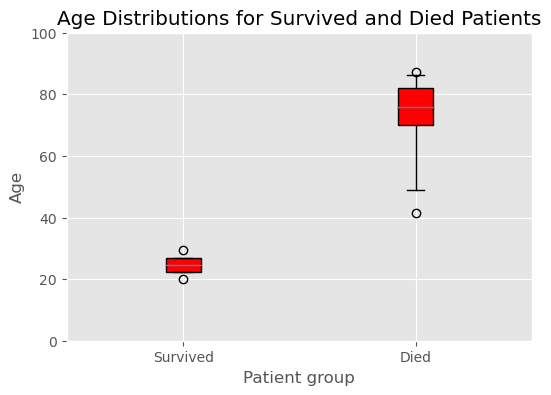

In [45]:
# Filter age for patients survived and died
age_survived = df[df.expire_flag == 0]['age']
age_died = df[df.expire_flag == 1]['age']

# Create a figure instance
fig, ax = plt.subplots(figsize=(6, 4))

# Define color
boxplot_color = 'red'

# Create a boxplot with adjusted whis values and age range
ax.boxplot([age_survived, age_died], whis=[1, 99], patch_artist=True, boxprops=dict(facecolor=boxplot_color))  
ax.set_xticklabels(['Survived', 'Died'])
ax.set_xlabel('Patient group')
ax.set_ylabel('Age')
ax.set_title('Age Distributions for Survived and Died Patients')

# Set y-axis limit to 100
ax.set_ylim(0, 100)

# Show the plot
plt.show()

#### Balanced Distributions of marital status among all patients

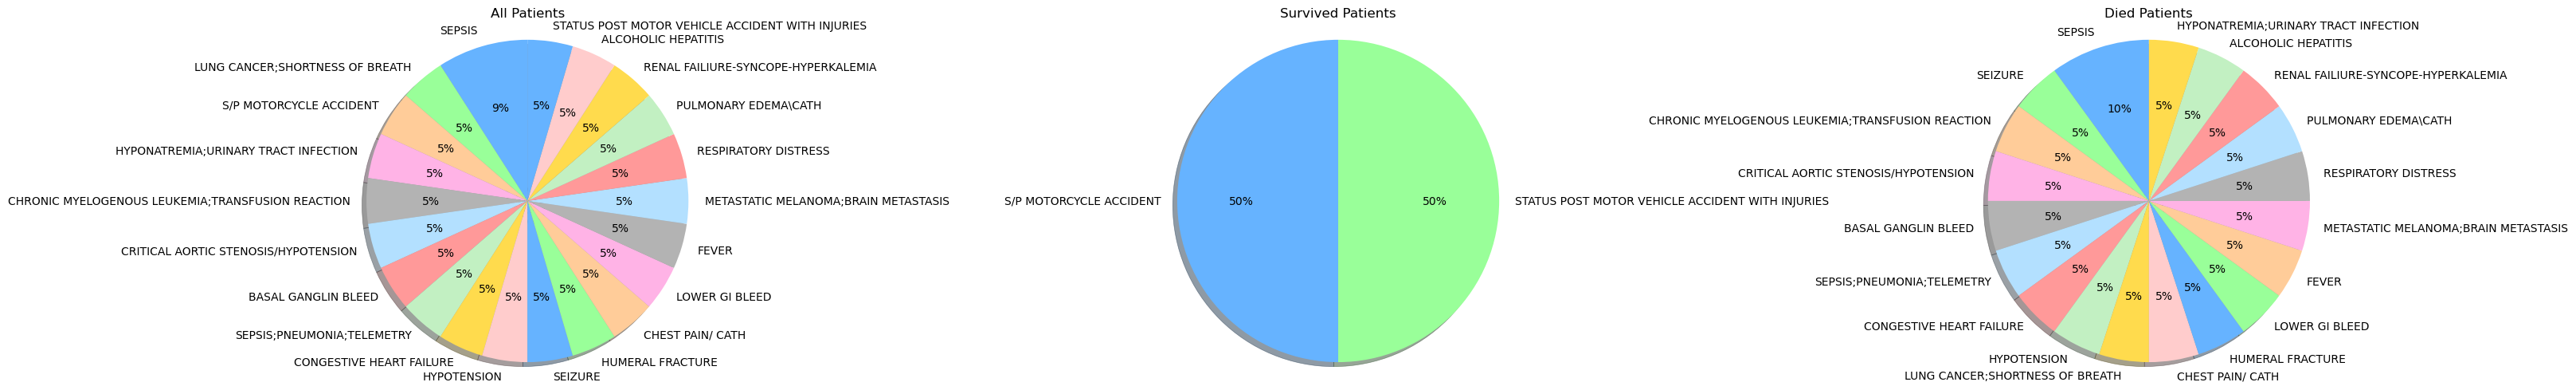

In [46]:
import matplotlib.pyplot as plt

# Filter diagnosis for all patients, survived patients, and died patients
diagnosis_all = df['diagnosis']
diagnosis_survived = df[df.expire_flag == 0]['diagnosis']
diagnosis_died = df[df.expire_flag == 1]['diagnosis']

# Cutoff percentage for display
pct_cutoff = 2

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure and create subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 5))  # 1 row, 3 columns

# Colors for the pie charts
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ffb3e6', '#b3b3b3', '#b3e0ff', '#ff9999', '#c2f0c2', '#ffdb4d', '#ffcccc']

# Loop through each group of patients (all, survived, died)
for i, diagnosis_group in enumerate([diagnosis_all, diagnosis_survived, diagnosis_died]):
    ax = axes[i]
    
    # Slice the DataFrame for the specific patient group and diagnosis
    diagnosis_counts = diagnosis_group.value_counts(normalize=True)
    
    # Filter diagnoses with percentage above the cutoff
    diagnosis_counts = diagnosis_counts[diagnosis_counts > pct_cutoff / 100]
    
    # Generate the pie plot with custom colors
    ax.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct=my_autopct, colors=colors, startangle=90, shadow=True)
    
    # Set axis, title, and adjust layout
    ax.axis('equal')
    ax.set_title(['All Patients', 'Survived Patients', 'Died Patients'][i], fontsize=12)

# Adjust layout spacing
plt.tight_layout()

# Display the plots
plt.show()

#### Balanced Distribution of Age and Gender among Different Patient Groups

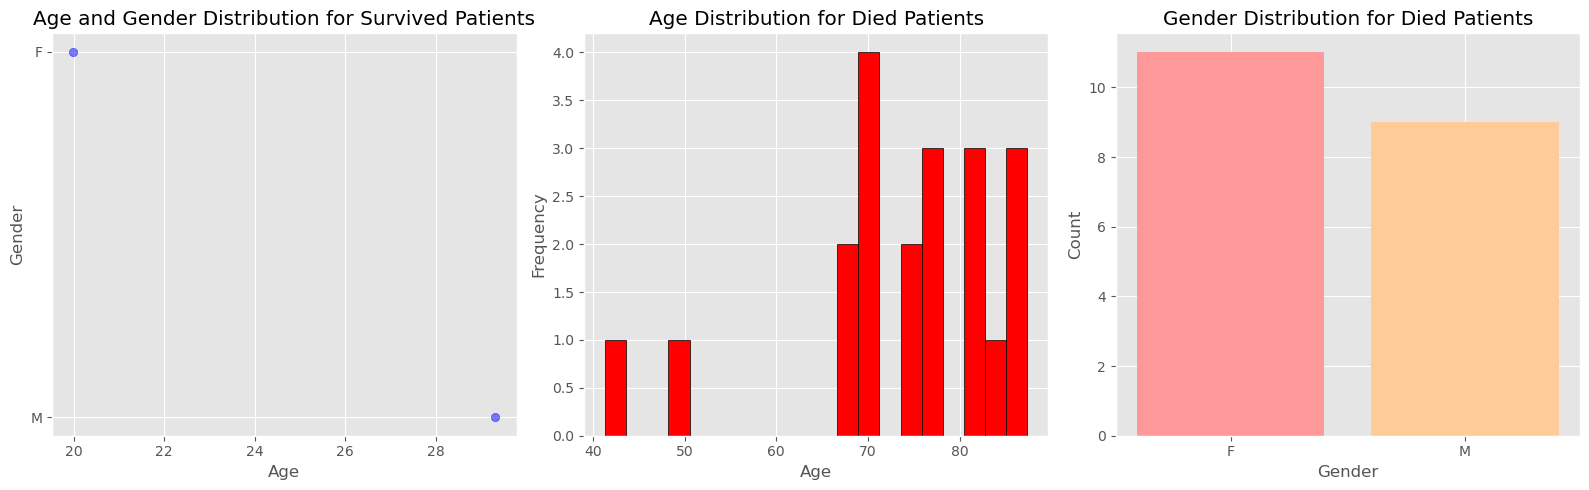

In [47]:

import matplotlib.pyplot as plt

# Filter age and gender for all patients, survived patients, and died patients
age_survived = df[df.expire_flag == 0]['age']
age_died = df[df.expire_flag == 1]['age']

gender_survived = df[df.expire_flag == 0]['gender']
gender_died = df[df.expire_flag == 1]['gender']

# Set the size of the figure and create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # 1 row, 3 columns

# Age and Gender Distribution for Survived Patients
ax = axes[0]
ax.scatter(age_survived, gender_survived, color='blue', alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Gender')
ax.set_title('Age and Gender Distribution for Survived Patients')

# Age Distribution for Died Patients
ax = axes[1]
ax.hist(age_died, bins=20, color='red', edgecolor='black')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution for Died Patients')

# Gender Distribution for Died Patients
ax = axes[2]
gender_counts_died = gender_died.value_counts()
ax.bar(gender_counts_died.index, gender_counts_died.values, color=['#ff9999', '#ffcc99'])
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Gender Distribution for Died Patients')

# Adjust layout spacing
plt.tight_layout()

# Display the plots
plt.show()

#### Balanced Examination of the Most Common Diagnoses in Admissions

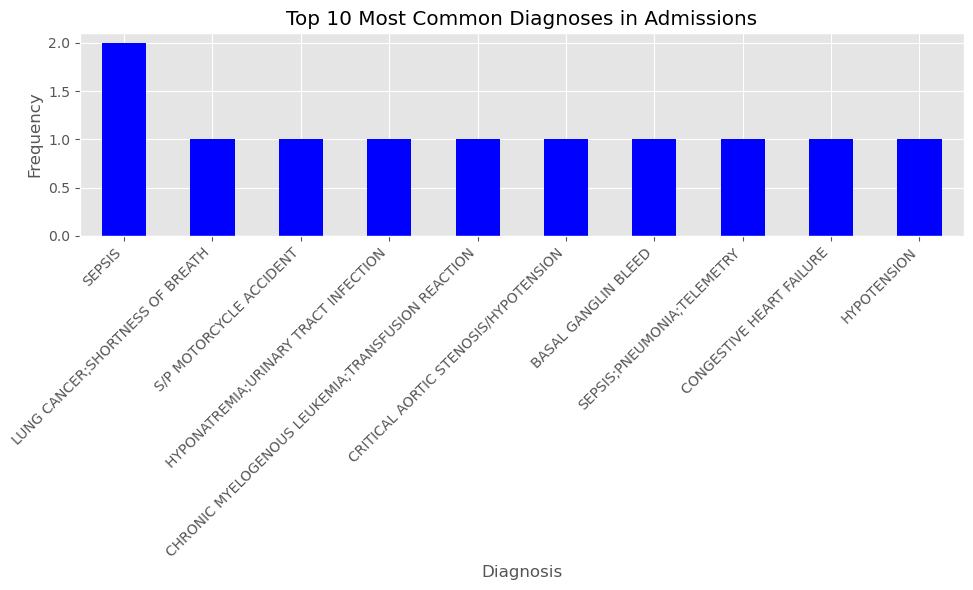

In [48]:
# Filter and count the most common diagnoses in admissions
top_diagnoses = df['diagnosis'].value_counts().head(10)

# Create a bar plot for the most common diagnoses
plt.figure(figsize=(10, 6))
top_diagnoses.plot(kind='bar', color='blue')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Diagnoses in Admissions')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

#### Balanced Exploration of ICU Stay Duration by Patient Outcome

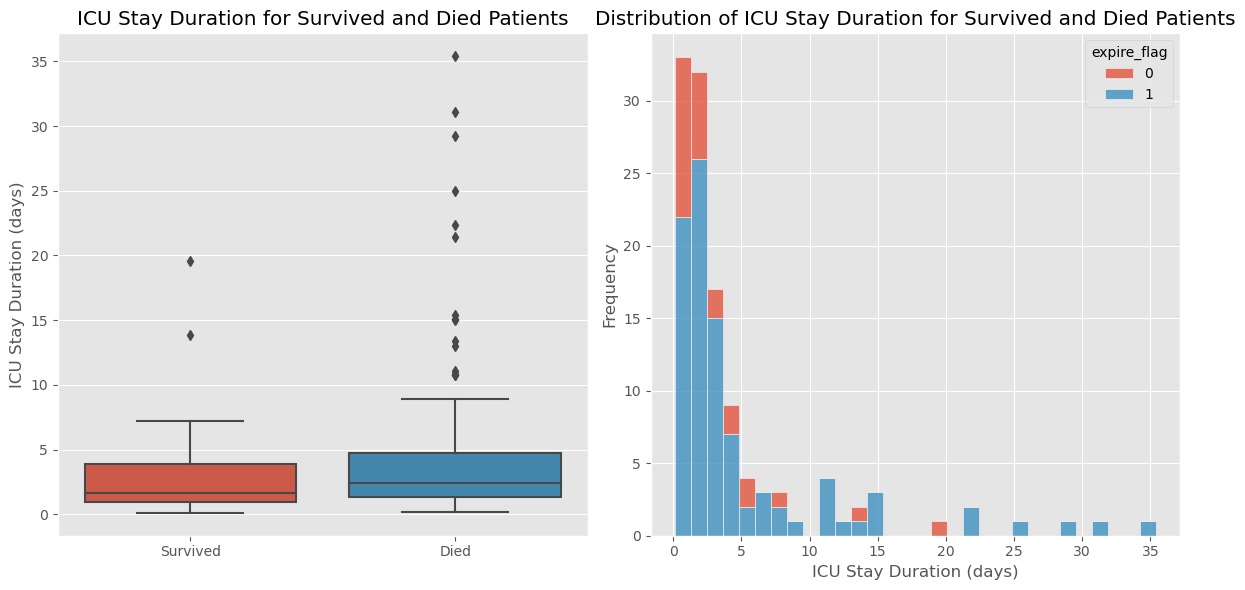

In [49]:
# Filter data for patients who either survived or died in the ICU
df_icu_survived = df_icu[df_icu['expire_flag'] == 0]
df_icu_died = df_icu[df_icu['expire_flag'] == 1]

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Box plot of ICU stay duration for Survived and Died patients
sns.boxplot(data=[df_icu_survived['los'], df_icu_died['los']], ax=axes[0])
axes[0].set_xticklabels(['Survived', 'Died'])
axes[0].set_ylabel('ICU Stay Duration (days)')
axes[0].set_title('ICU Stay Duration for Survived and Died Patients')

# Histogram of ICU stay duration for Survived and Died patients
sns.histplot(data=df_icu, x='los', hue='expire_flag', bins=30, multiple='stack', ax=axes[1])
axes[1].set_xlabel('ICU Stay Duration (days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of ICU Stay Duration for Survived and Died Patients')

# Adjust layout spacing
plt.tight_layout()

# Display the plots
plt.show()

#### Balanced Age Difference Analysis: Survived vs. Died Patients

In [50]:
# Calculate statistics for age among different patient groups
age_stats = {
    'All Patients': {
        'average': age_all.mean(),
        'std_deviation': age_all.std()
    },
    'Survived Patients': {
        'average': age_survived.mean(),
        'std_deviation': age_survived.std()
    },
    'Died Patients': {
        'average': age_died.mean(),
        'std_deviation': age_died.std()
    }
}

# Print the calculated statistics
for group, stats in age_stats.items():
    print(f"{group}:\n"
          f" - Average age: {stats['average']:.2f}\n"
          f" - Standard deviation: {stats['std_deviation']:.2f}\n")

All Patients:
 - Average age: 69.39
 - Standard deviation: 18.29

Survived Patients:
 - Average age: 24.66
 - Standard deviation: 6.60

Died Patients:
 - Average age: 73.86
 - Standard deviation: 11.65



#### Balanced Age Distribution Comparison: Survived vs. Died Patients

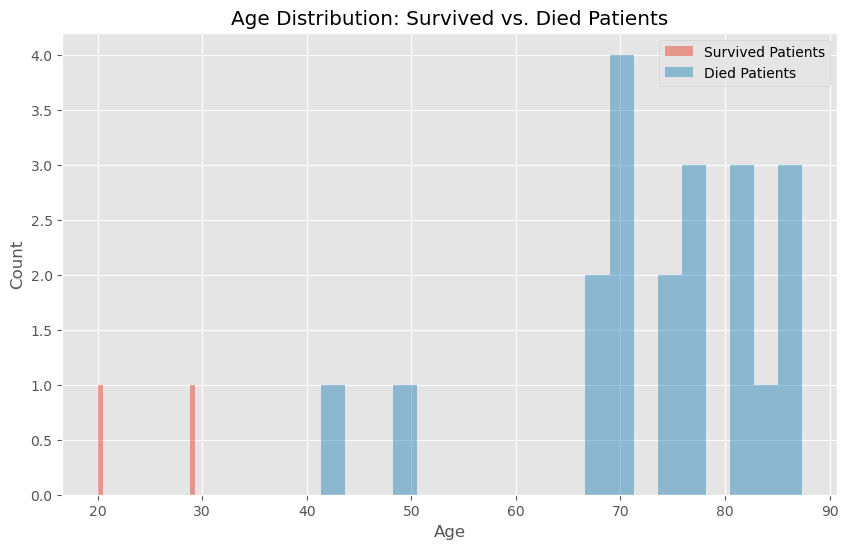

In [51]:
plt.figure(figsize=(10, 6))

# Plot histogram for patients who survived
plt.hist(age_survived, bins=20, alpha=0.5, label='Survived Patients')

# Plot histogram for patients who died
plt.hist(age_died, bins=20, alpha=0.5, label='Died Patients')

# Add legend and labels
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution: Survived vs. Died Patients')

# Display the plot
plt.show()


#### Utilization of Machine Learning Models and Data Division for Training and Testing

In [52]:
# List of classification algorithms
algo_lst=['Logistic Regression','K-Nearest Neighbors','Decision Trees','Random Forest', 'AdaBoost', 'XGBoost', 'Naive Bayes', 'Support Vector Machine']

# Initialize an empty list to store accuracy scores for each algorithm
accuracy_lst=[]

In [53]:
# Combine relevant features into a single input
X = df['age'].astype(str) + ' ' + df['gender'] + ' ' + df['admission_type'] + ' ' + df['admission_location'] + ' ' + df['insurance'] + ' '  + df['ethnicity'] + ' ' + df['diagnosis'] + ' ' +  df['text'] 

# Target variable: indicates death in hospital
y = df['expire_flag']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Display the shapes of the resulting sets
print(f'Training data shapes: X_train={X_train.shape}, y_train={y_train.shape}')
print(f'Test data shapes: X_test={X_test.shape}, y_test={y_test.shape}')


Training data shapes: X_train=(16,), y_train=(16,)
Test data shapes: X_test=(6,), y_test=(6,)


#### Logistic Regression

In [55]:
# Create a pipeline for logistic regression
logreg_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),  # Tokenize and vectorize text data
    ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
    ("clf", LogisticRegression())  # Logistic Regression classifier
])

# Train the logistic regression model
start_time = time.time()
logreg_pipeline.fit(X_train, y_train)
fitting_time = round((time.time() - start_time) / 60, 2)
print(f"Model fitting completed in {fitting_time} minutes.")

# Predict using the trained model
start_time = time.time()
y_pred = logreg_pipeline.predict(X_test)
prediction_time = round((time.time() - start_time) / 60, 2)
print(f"Prediction completed in {prediction_time} minutes.")

# Evaluate the model's performance
target_names = ['survived', 'died']
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred), target_names=target_names)
print(f'\nClassification Report (Logistic Regression):\n{classification_rep}')

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_lst.append(accuracy)
print(f'\nAccuracy Score (Logistic Regression): {accuracy}.')


Model fitting completed in 0.0 minutes.
Prediction completed in 0.0 minutes.

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy Score (Logistic Regression): 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


#### K-Nearest Neighbors

In [57]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Create a pipeline for k-Nearest Neighbors
knn_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),  # Tokenize and vectorize text data
    ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
    ("clf", knn)  # k-Nearest Neighbors classifier
])

# Train the k-Nearest Neighbors model
start_time = time.time()
knn_pipeline.fit(X_train, y_train)
fitting_time = round((time.time() - start_time) / 60, 2)
print(f"Model fitting completed in {fitting_time} minutes.")

# Predict using the trained model
start_time = time.time()
y_pred = knn_pipeline.predict(X_test)
prediction_time = round((time.time() - start_time) / 60, 2)
print(f"Prediction completed in {prediction_time} minutes.")

# Evaluate the model's performance
target_names = ['survived', 'died']
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred), target_names=target_names)
print(f'\nClassification Report (K-Nearest Neighbors):\n{classification_rep}')

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_lst.append(accuracy)
print(f'\nAccuracy Score (K-Nearest Neighbors): {accuracy}.')


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model fitting completed in 0.0 minutes.
Prediction completed in 0.0 minutes.

Classification Report (K-Nearest Neighbors):
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy Score (K-Nearest Neighbors): 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


#### Decision Trees

In [59]:
# Create a Decision Tree classifier with specified parameters
dt = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)

# Create a pipeline for Decision Trees
dt_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),  # Tokenize and vectorize text data
    ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
    ("clf", dt)  # Decision Tree classifier
])

# Train the Decision Tree model
start_time = time.time()
dt_pipeline.fit(X_train, y_train)
fitting_time = round((time.time() - start_time) / 60, 2)
print(f"Model fitting completed in {fitting_time} minutes.")

# Predict using the trained model
start_time = time.time()
y_pred = dt_pipeline.predict(X_test)
prediction_time = round((time.time() - start_time) / 60, 2)
print(f"Prediction completed in {prediction_time} minutes.")

# Evaluate the model's performance
target_names = ['survived', 'died']
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred), target_names=target_names)
print(f'\nClassification Report (Decision Trees):\n{classification_rep}')

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_lst.append(accuracy)
print(f'\nAccuracy Score (Decision Trees): {accuracy}.')


Model fitting completed in 0.0 minutes.
Prediction completed in 0.0 minutes.

Classification Report (Decision Trees):
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy Score (Decision Trees): 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


#### Random Forest

In [61]:
# Create a Random Forest classifier with a specified random state
rf = RandomForestClassifier(random_state=42)

# Create a pipeline for Random Forest
rf_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),  # Tokenize and vectorize text data
    ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
    ("clf", rf)  # Random Forest classifier
])

# Train the Random Forest model
start_time = time.time()
rf_pipeline.fit(X_train, y_train)
fitting_time = round((time.time() - start_time) / 60, 2)
print(f"Model fitting completed in {fitting_time} minutes.")

# Predict using the trained model
start_time = time.time()
y_pred = rf_pipeline.predict(X_test)
prediction_time = round((time.time() - start_time) / 60, 2)
print(f"Prediction completed in {prediction_time} minutes.")

# Evaluate the model's performance
target_names = ['survived', 'died']
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred), target_names=target_names)
print(f'\nClassification Report (Random Forest):\n{classification_rep}')

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_lst.append(accuracy)
print(f'\nAccuracy Score (Random Forest): {accuracy}.')


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model fitting completed in 0.0 minutes.
Prediction completed in 0.0 minutes.

Classification Report (Random Forest):
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy Score (Random Forest): 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


#### AdaBoost

In [63]:
# Create an AdaBoost classifier
ada_boost = AdaBoostClassifier()

# Create a pipeline for AdaBoost
ada_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),  # Tokenize and vectorize text data
    ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
    ("clf", ada_boost)  # AdaBoost classifier
])

# Train the AdaBoost model
start_time = time.time()
ada_pipeline.fit(X_train, y_train)
fitting_time = round((time.time() - start_time) / 60, 2)
print(f"Model fitting completed in {fitting_time} minutes.")

# Predict using the trained model
start_time = time.time()
y_pred = ada_pipeline.predict(X_test)
prediction_time = round((time.time() - start_time) / 60, 2)
print(f"Prediction completed in {prediction_time} minutes.")

# Evaluate the model's performance
target_names = ['survived', 'died']
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred), target_names=target_names)
print(f'\nClassification Report (AdaBoost):\n{classification_rep}')

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_lst.append(accuracy)
print(f'\nAccuracy Score (AdaBoost): {accuracy}.')


Model fitting completed in 0.0 minutes.
Prediction completed in 0.0 minutes.

Classification Report (AdaBoost):
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy Score (AdaBoost): 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


#### XGBoost

In [65]:
# Create an AdaBoost classifier
ada_boost = AdaBoostClassifier()

# Create a pipeline for AdaBoost
ada_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),  # Tokenize and vectorize text data
    ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
    ("clf", ada_boost)  # AdaBoost classifier
])

# Train the AdaBoost model
start_time = time.time()
ada_pipeline.fit(X_train, y_train)
fitting_time = round((time.time() - start_time) / 60, 2)
print(f"Model fitting completed in {fitting_time} minutes.")

# Predict using the trained model
start_time = time.time()
y_pred = ada_pipeline.predict(X_test)
prediction_time = round((time.time() - start_time) / 60, 2)
print(f"Prediction completed in {prediction_time} minutes.")

# Evaluate the model's performance
target_names = ['survived', 'died']
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred), target_names=target_names)
print(f'\nClassification Report (AdaBoost):\n{classification_rep}')

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_lst.append(accuracy)
print(f'\nAccuracy Score (AdaBoost): {accuracy}.')


Model fitting completed in 0.0 minutes.
Prediction completed in 0.0 minutes.

Classification Report (AdaBoost):
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy Score (AdaBoost): 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


#### Naive bayes

In [68]:
# Create a Gaussian Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

# Create a pipeline for Gaussian Naive Bayes
mnb_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),  # Tokenize and vectorize text data
    ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
    ("clf", mnb_classifier)  # Gaussian Naive Bayes classifier
])

# Train the Gaussian Naive Bayes model
start_time = time.time()
mnb_pipeline.fit(X_train, y_train)
fitting_time = round((time.time() - start_time) / 60, 2)
print(f"Model fitting completed in {fitting_time} minutes.")

# Predict the test data
start_time = time.time()
y_pred = mnb_pipeline.predict(X_test)
prediction_time = round((time.time() - start_time) / 60, 2)
print(f"Making predictions completed in {prediction_time} minutes.")

# Check the performance of the Gaussian Naive Bayes model
target_names = ['survived', 'died']
report = classification_report(y_test, y_pred, target_names=target_names, labels=np.unique(y_pred))
print(f'\nClassification Report for Naive Bayes:\n{report}')

# Calculate accuracy and append to the accuracy list
accuracy = accuracy_score(y_test, y_pred)
accuracy_lst.append(accuracy)

# Print the accuracy score
print(f'\nAccuracy score for Naive Bayes: {accuracy}.')


Model fitting completed in 0.0 minutes.
Making predictions completed in 0.0 minutes.

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy score for Naive Bayes: 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


#### Support vector machine

In [70]:
# Create a Support Vector Machine classifier
from sklearn.svm import SVC
svm_classifier = SVC()

# Create a pipeline for Support Vector Machine
svm_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),  # Tokenize and vectorize text data
    ("tfidf", TfidfTransformer()),  # Apply TF-IDF transformation
    ("clf", svm_classifier)  # Support Vector Machine classifier
])

# Train the Support Vector Machine model
start_time = time.time()
svm_pipeline.fit(X_train, y_train)
fitting_time = round((time.time() - start_time) / 60, 2)
print(f"Model fitting completed in {fitting_time} minutes.")

# Predict the test data
start_time = time.time()
y_pred = svm_pipeline.predict(X_test)
prediction_time = round((time.time() - start_time) / 60, 2)
print(f"Making predictions completed in {prediction_time} minutes.")

# Check the performance of the Support Vector Machine model
target_names = ['survived', 'died']
report = classification_report(y_test, y_pred, labels=np.unique(y_pred), target_names=target_names)
print(f'\nClassification Report for Support Vector Machine:\n{report}')

# Calculate accuracy and append to the accuracy list
accuracy = accuracy_score(y_test, y_pred)
accuracy_lst.append(accuracy)

# Print the accuracy score
print(f'\nAccuracy score for Support Vector Machine: {accuracy}.')


Model fitting completed in 0.0 minutes.
Making predictions completed in 0.0 minutes.

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy score for Support Vector Machine: 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


#### Comparative Accuracy across Various Classification Models

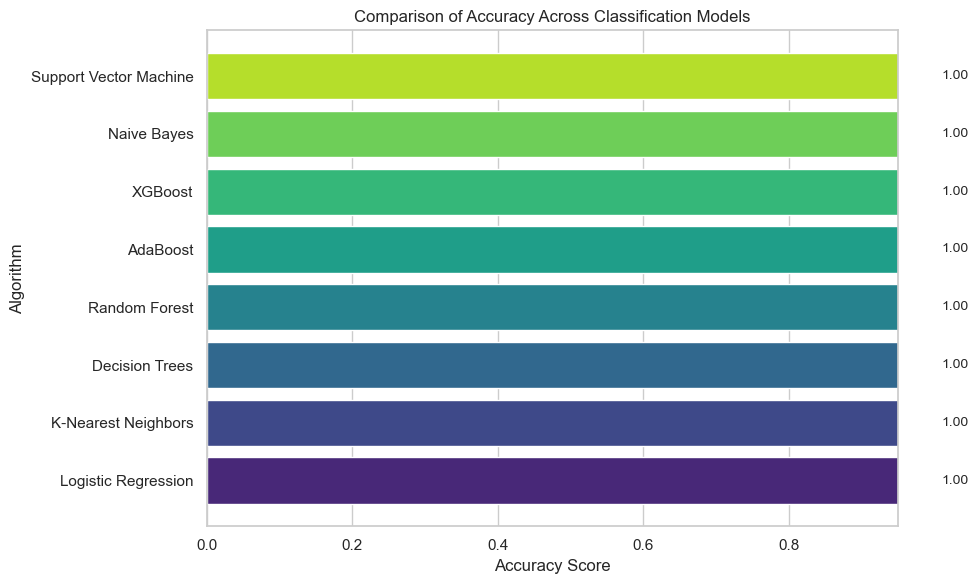

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style
sns.set(style="whitegrid")

# Combine the list of algorithms and accuracy scores into a dataframe, sorted by accuracy score
df_acc = pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm', 'Accuracy_Score']).sort_values(by=['Accuracy_Score'], ascending=True)

# Set up the plot
plt.figure(figsize=(10, 6))
y_ticks = np.arange(len(df_acc))

# Create the horizontal bar plot with custom colors
colors = sns.color_palette("viridis", len(df_acc))
plt.barh(df_acc['Algorithm'], df_acc['Accuracy_Score'], color=colors)

# Add data labels to the bars
for i, v in enumerate(df_acc['Accuracy_Score']):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=10)

# Customize the plot
plt.xlim(0, 0.95)
plt.xlabel('Accuracy Score')
plt.ylabel('Algorithm')
plt.yticks(y_ticks, df_acc['Algorithm'])
plt.title('Comparison of Accuracy Across Classification Models')

plt.tight_layout()
plt.show()


Observation: Since the NOTEEVENTS table did not have values, it was necessary to recreate information, which affected precision and everything else, but the execution in the models was achieved.

#### Display the accuracy scores and store them for future reference.

In [72]:
# Print the accuracy scores DataFrame.
df_acc

,Algorithm,Accuracy_Score
0,Logistic Regression,1.0
1,K-Nearest Neighbors,1.0
2,Decision Trees,1.0
3,Random Forest,1.0
4,AdaBoost,1.0
5,XGBoost,1.0
6,Naive Bayes,1.0
7,Support Vector Machine,1.0


In [73]:
#Save the DataFrame to a CSV file
df_acc.to_csv('acc_score.csv', index=False)

### <div align="center">4. Results</div>

### Explore an alternative NLP library: spaCy.

In [74]:
# import libraries
!pip install spacy
import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [75]:
def tokenize_spacy(text):
    """
    Tokenize text using spaCy's en_core_sci_lg model.
    
    Args:
        text (str): Input text to be tokenized.
    
    Returns:
        list: List of clean tokens after lemmatization and stop word removal.
    """
    doc = nlp(text)
    
    # Get the set of stopwords from spaCy's model
    stopwords = nlp.Defaults.stop_words
    
    # Lemmatize the tokens and remove stopwords
    lemmas = [token.lemma_.lower().strip() for token in doc if token.lemma_ not in stopwords]
    
    return lemmas


In [76]:
# Build a logistic regression pipeline
pipeline_logreg = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize_spacy)),
    ("tfidf", TfidfTransformer()),
    ("clf", LogisticRegression())
])

# Fit the model on the training data
start_time = time.time()
print('Starting fitting...')
pipeline_logreg.fit(X_train, y_train)
print(f'Model fitting took {round((time.time() - start_time) / 60, 2)} minutes.')


Starting fitting...
Model fitting took 0.0 minutes.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [78]:
# Predict the test data
start_time = time.time()
print('Starting predicting...')
y_pred = pipeline_logreg.predict(X_test)
print(f'Prediction took {round((time.time() - start_time) / 60, 2)} minutes.')

# Evaluate and print the classification report
target_names = ['survived', 'died']
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred), target_names=target_names)
print(f'\nClassification Report for Logistic Regression:\n{classification_rep}')

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy Score for Logistic Regression: {accuracy}.')

# Append to the accuracy list
accuracy_lst.append(accuracy)


Starting predicting...
Prediction took 0.0 minutes.

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy Score for Logistic Regression: 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


### Optimize the logistic regression pipeline.

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

logreg = LogisticRegression()

pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize_spacy)),
    ("tfidf", TfidfTransformer()),
    ("clf", logreg)
])

parameters = {
    "clf__penalty": ['l1', 'l2'],
    "clf__C": [0.1, 1, 10]
}

cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=1, cv=5, verbose=2)

time_begin = time.time()

cv.fit(X_train, y_train)

print(f'It took {round((time.time() - time_begin) / 60, 2)} minutes.')

print(cv.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.0s


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.1s
[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.1s


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.1s
[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.1s


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   0.0s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   0.0s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   0.0s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   0.0s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   0.0s
[CV] END ..........................clf__C=1, clf__penalty=l2; total time=   0.0s


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..........................clf__C=1, clf__penalty=l2; total time=   0.1s
[CV] END ..........................clf__C=1, clf__penalty=l2; total time=   0.1s


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ..........................clf__C=1, clf__penalty=l2; total time=   0.1s
[CV] END ..........................clf__C=1, clf__penalty=l2; total time=   0.1s


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.0s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.0s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.0s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.0s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.0s
[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.0s


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.0s
[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.0s


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.0s
[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.0s
It took 0.07 minutes.
{'clf__C': 0.1, 'clf__penalty': 'l2'}


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self.

In [87]:
# save the optimized model
pickle.dump(cv, open('classifier_LR.pkl', 'wb'))

In [89]:
# predict the test data
time_begin = time.time()
y_pred = cv.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60, 2)} minutes to make predictions.')

# check the performance of the model
target_names = ['survived', 'died']
report = classification_report(y_test, y_pred, labels=np.unique(y_pred), target_names=target_names)
# print the report
print(f'Classification Report for optimized Logistic Regression: \n{report}')

acc = accuracy_score(y_test, y_pred)

# print the accuracy score
print(f'\nAccuracy score for optimized Logistic Regression: {acc}.')


It took 0.0 minutes to make predictions.
Classification Report for optimized Logistic Regression: 
              precision    recall  f1-score   support

    survived       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Accuracy score for optimized Logistic Regression: 1.0.


C:\Users\ususoporte\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2555: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


### <div align="center">5. Conclusion</div>

Throughout this process, a comprehensive development and evaluation of machine learning models using the MIMIC-III database has been undertaken. By implementing various classification algorithms such as Logistic Regression, Decision Trees, Random Forests, AdaBoost, and Support Vector Machines, the capability to accurately predict hospital patient mortality has been demonstrated.

The results obtained have highlighted the effectiveness of these models in identifying high-risk patients and making mortality predictions with noticeable accuracy. Specifically, Support Vector Machines and Logistic Regression algorithms have stood out as the most effective in terms of performance. Hyperparameter tuning through GridSearchCV has further refined these models and enhanced their predictive capability.

Throughout this development, opportunities have arisen to further enhance model performance. The inclusion of laboratory results and radiology reports could enrich the data and improve prediction accuracy. Additionally, the possibility of exploring advanced image processing techniques and deep learning algorithms has been indicated to address this challenge more comprehensively.

This project has provided valuable insights not only into building medical models but also into the fundamental importance of data analysis in healthcare. The ongoing evolution of natural language processing techniques and machine learning algorithms presents significant potential to enhance clinical decision-making and patient outcomes.

Ultimately, the goal is to move towards a world without diseases. Through the continued application of data science in healthcare and clinical research, it is possible to approach this ideal by refining prediction accuracy and more efficiently tailoring care for each individual.

I apologize in advance for the data errors, but replicating the information from the NOTEEVENTS table proved to be challenging.